In [15]:
# === Cell 1: Imports & setup ===
import os
import warnings
from typing import Iterator, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.tseries.offsets import MonthEnd
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Quiet common non-fatal warnings globally (optional)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="No frequency information was provided")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")

# Paths / IO
DATA_DIR = "../DATA"
OUTPUT_DIR = "../OUTPUTS"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load the cleaned long-format file created earlier
data_path = os.path.join(DATA_DIR, "zhvi_clean_long.csv")
zhvi = pd.read_csv(data_path, parse_dates=["date"])
zhvi.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275660 entries, 0 to 275659
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   RegionID    275660 non-null  int64         
 1   SizeRank    275660 non-null  int64         
 2   RegionName  275660 non-null  object        
 3   RegionType  275660 non-null  object        
 4   StateName   275352 non-null  object        
 5   date        275660 non-null  datetime64[ns]
 6   zhvi        275660 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 14.7+ MB


In [16]:
# === Cell 2: Config ===
METROS = ["New York, NY", "Los Angeles, CA", "Chicago, IL", "San Francisco, CA", "Miami, FL"]
HORIZONS = [3, 6, 12]  # months
M = 12                 # seasonal period for monthly data
MIN_YEARS = 10

# Keep only metros present in data
present = set(zhvi["RegionName"].unique())
METROS = [m for m in METROS if m in present]
METROS


['New York, NY',
 'Los Angeles, CA',
 'Chicago, IL',
 'San Francisco, CA',
 'Miami, FL']

In [17]:
# === Cell 3: Frequency & hygiene helpers ===
def ensure_month_end(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["date"] = pd.to_datetime(out["date"], errors="coerce") + MonthEnd(0)
    return out

def assert_monotonic_by_region(df: pd.DataFrame):
    bad = []
    for r, g in df.groupby("RegionName"):
        if not g.sort_values("date")["date"].is_monotonic_increasing:
            bad.append(r)
    if bad:
        raise ValueError(f"Non-monotonic timestamps for: {bad}")

def ensure_monthly_freq(s: pd.Series) -> pd.Series:
    """Ensure a DatetimeIndex with explicit month-end freq and filled gaps."""
    s = s.copy()
    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index, errors="coerce")
    s.index = s.index + MonthEnd(0)
    # try to set freq directly; if gaps exist, reindex and interpolate
    try:
        s = s.asfreq("M")
    except ValueError:
        full = pd.date_range(s.index.min(), s.index.max(), freq="M")
        s = s.reindex(full).interpolate(limit_direction="both").asfreq("M")
    return s

def series_for_region(df: pd.DataFrame, region: str) -> pd.Series:
    g = df[df["RegionName"] == region].sort_values("date")
    s = g.set_index("date")["zhvi"].astype(float)
    return ensure_monthly_freq(s)

# apply base hygiene
zhvi = ensure_month_end(zhvi)
assert_monotonic_by_region(zhvi)


In [18]:
# === Cell 4: Rolling-origin folds ===
def rolling_origin_folds(series: pd.Series,
                         train_min: int = 120,  # 10 years
                         val_h: int = 12,
                         test_h: int = 12,
                         step: int = 3) -> Iterator[Dict[str, Any]]:
    s = ensure_monthly_freq(series).sort_index()
    n = len(s)
    t_end = train_min
    while t_end + val_h + test_h <= n:
        yield {
            "train": s.iloc[:t_end],
            "val":   s.iloc[t_end:t_end+val_h],
            "test":  s.iloc[t_end+val_h:t_end+val_h+test_h]
        }
        t_end += step

# sanity check on one metro
s0 = series_for_region(zhvi, METROS[0])
len(list(rolling_origin_folds(s0, 120, 12, 12, 3)))


/var/folders/6_/d2b5ghqd0xg8f3nn8swx97c40000gn/T/ipykernel_28906/3332687684.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.asfreq("M")


55

In [19]:
# === Cell 5: Stationarity tests & differencing suggestions ===
def adf_pvalue(x):
    x = pd.Series(x).dropna()
    return adfuller(x, autolag="AIC")[1] if len(x) > 15 else np.nan

def kpss_pvalue(x):
    x = pd.Series(x).dropna()
    if len(x) <= 15:
        return np.nan
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            p = kpss(x, regression="c", nlags="auto")[1]
        return float(min(max(p, 1e-6), 0.999999))  # clamp
    except Exception:
        return np.nan

def suggest_d(series, max_d=2):
    s = series.copy()
    for d in range(max_d+1):
        p_adf, p_kpss = adf_pvalue(s), kpss_pvalue(s)
        if (not np.isnan(p_adf) and p_adf < 0.05) and (np.isnan(p_kpss) or p_kpss > 0.05):
            return d
        s = s.diff().dropna()
    return min(max_d, 1)

def suggest_D(series, m=12, max_D=1):
    if max_D == 0: 
        return 0
    s0 = series.dropna()
    if len(s0) < m*3:
        return 0
    sd0 = s0.std()
    s1 = s0.diff(m).dropna()
    # seasonal diff if variance drops and ADF improves
    if s1.std() < 0.9*sd0 and adf_pvalue(s1) < max(0.10, adf_pvalue(s0) or 1.0):
        return 1
    return 0

# quick demo
for r in METROS[:2]:
    s = series_for_region(zhvi, r)
    print(r, "d:", suggest_d(s), "D:", suggest_D(s, m=12))


New York, NY d: 2 D: 1
Los Angeles, CA d: 1 D: 1


/var/folders/6_/d2b5ghqd0xg8f3nn8swx97c40000gn/T/ipykernel_28906/3332687684.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.asfreq("M")
/var/folders/6_/d2b5ghqd0xg8f3nn8swx97c40000gn/T/ipykernel_28906/3332687684.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.asfreq("M")


/var/folders/6_/d2b5ghqd0xg8f3nn8swx97c40000gn/T/ipykernel_28906/3332687684.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.asfreq("M")


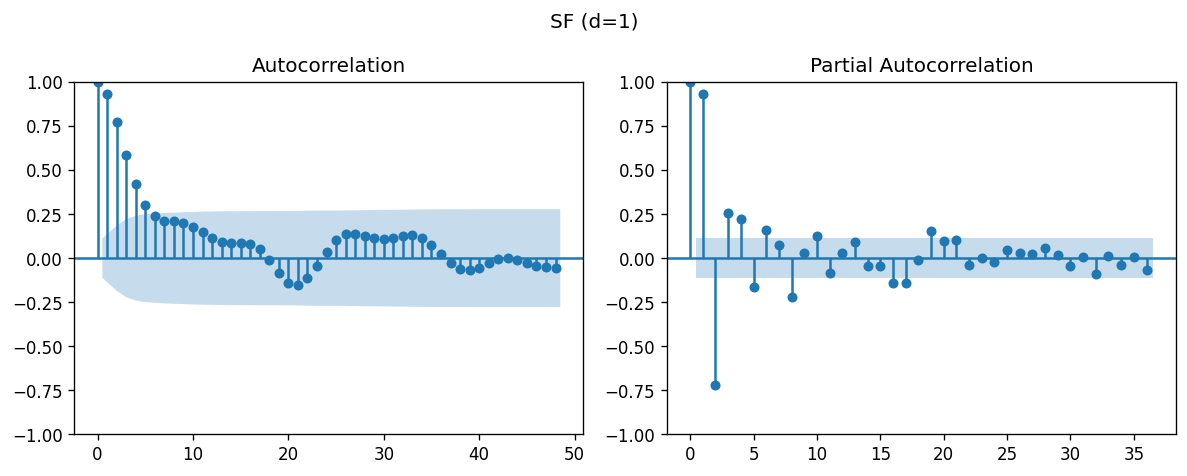

In [21]:
# === Cell 6: ACF/PACF helper (optional) ===
def show_acf_pacf(series, title="", lags=48):
    fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=120)
    plot_acf(series.dropna(), lags=lags, ax=ax[0])
    plot_pacf(series.dropna(), lags=min(lags, 36), ax=ax[1])
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Example:
show_acf_pacf(series_for_region(zhvi, "San Francisco, CA").diff().dropna(), "SF (d=1)")


In [22]:
# === Cell 7: SARIMA fit utility ===
def aicc(llf, nobs, k_params):
    aic = 2*k_params - 2*llf
    return np.inf if (nobs - k_params - 1) <= 0 else aic + (2*k_params*(k_params+1)) / (nobs - k_params - 1)

def fit_sarima(y, order, seasonal_order, enforce_stationarity=False, enforce_invertibility=False):
    y = ensure_monthly_freq(pd.Series(y))
    model = SARIMAX(y, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=enforce_stationarity,
                    enforce_invertibility=enforce_invertibility)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        try:
            res = model.fit(method="lbfgs", maxiter=200, disp=False)
        except Exception:
            res = model.fit(method="powell", maxiter=200, disp=False)

    lb = acorr_ljungbox(res.resid.dropna(), lags=[12], return_df=True)["lb_pvalue"].iloc[0]
    k = res.params.shape[0]
    return res, dict(aicc=aicc(res.llf, res.nobs, k), aic=res.aic, bic=res.bic, lb_pvalue=float(lb))


In [23]:
# === Cell 8: Candidate grid & selection ===
def candidate_orders(d, D, m=M):
    Ps, Qs = [0,1], [0,1]
    ps, qs = [0,1,2], [0,1,2]
    grid = []
    for p in ps:
        for q in qs:
            for P in Ps:
                for Q in Qs:
                    grid.append(((p,d,q),(P,D,Q,m)))
    return grid

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return float(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

def choose_best_order_by_val(train, val, d, D, m=M):
    best = None
    for order, sorder in candidate_orders(d, D, m):
        try:
            res, diag = fit_sarima(train, order, sorder)
            fc = res.get_forecast(steps=len(val)).predicted_mean
            score = mape(val.values, fc.values)
            item = dict(order=order, seasonal_order=sorder, mape_val=score, **diag)
            if (best is None) or (score < best["mape_val"]) or (score == best["mape_val"] and diag["aicc"] < best["aicc"]):
                best = item
        except Exception:
            continue
    return best


In [24]:
# === Cell 9: Backtest across horizons ===
def rmse(y, yhat): return float(np.sqrt(mean_squared_error(y, yhat)))
def mae(y, yhat):  return float(mean_absolute_error(y, yhat))
def smape(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    return float(100*np.mean(2*np.abs(yhat-y) / (np.abs(y)+np.abs(yhat) + 1e-9)))

def backtest_region(series, horizons=HORIZONS, train_min=120, step=3):
    results = []
    for fold_idx, fold in enumerate(rolling_origin_folds(series, train_min=train_min, val_h=12, test_h=max(horizons), step=step)):
        train, val, test_full = fold["train"], fold["val"], fold["test"]
        d, D = suggest_d(train), suggest_D(train, m=M)
        best = choose_best_order_by_val(train, val, d, D, M)
        if best is None:
            continue
        try:
            res, diag = fit_sarima(pd.concat([train, val]), best["order"], best["seasonal_order"])
        except Exception:
            continue
        for h in horizons:
            if len(test_full) < h:
                continue
            test = test_full.iloc[:h]
            fc = res.get_forecast(steps=h).predicted_mean
            results.append({
                "fold": fold_idx,
                "h": h,
                "order": best["order"],
                "seasonal_order": best["seasonal_order"],
                "mape_val": best["mape_val"],
                "aicc": best["aicc"],
                "bic": best["bic"],
                "lb_pvalue": diag["lb_pvalue"],
                "RMSE": rmse(test.values, fc.values),
                "MAE": mae(test.values, fc.values),
                "MAPE": mape(test.values, fc.values),
                "sMAPE": smape(test.values, fc.values),
            })
    return pd.DataFrame(results)


In [33]:
# === Cell 10: Execute backtests for selected metros ===
METROS = [
    "New York, NY",
    "Los Angeles, CA",
    "Chicago, IL",
    "San Francisco, CA",
    "Miami, FL",     # NOTE: avoids Miami, OK
]

all_results = []
for region in METROS:
    s = series_for_region(zhvi, region)
    if len(s) < 120 + 12 + max(HORIZONS):
        print(f"Skipping {region}: not enough history.")
        continue
    df_res = backtest_region(s, horizons=HORIZONS, train_min=120, step=3)
    df_res["RegionName"] = region
    all_results.append(df_res)

eval_table = pd.concat(all_results, ignore_index=True) if all_results else pd.DataFrame()
print("Shape:", eval_table.shape)
eval_table.groupby(["RegionName","h"]).agg({"MAPE":"mean","RMSE":"mean","MAE":"mean","sMAPE":"mean"})


/var/folders/6_/d2b5ghqd0xg8f3nn8swx97c40000gn/T/ipykernel_28906/3332687684.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.asfreq("M")
/var/folders/6_/d2b5ghqd0xg8f3nn8swx97c40000gn/T/ipykernel_28906/3332687684.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.asfreq("M")
/var/folders/6_/d2b5ghqd0xg8f3nn8swx97c40000gn/T/ipykernel_28906/3332687684.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.asfreq("M")
/var/folders/6_/d2b5ghqd0xg8f3nn8swx97c40000gn/T/ipykernel_28906/3332687684.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.asfreq("M")
/var/folders/6_/d2b5ghqd0xg8f3nn8swx97c40000gn/T/ipykernel_28906/3332687684.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.as

Shape: (825, 13)


MAPE          RMSE           MAE     sMAPE
RegionName        h                                                 
Chicago, IL       3   0.474094   1312.786684   1152.058881  0.475458
                  6   0.939860   2830.481746   2362.792248  0.946996
                  12  1.970312   6105.289393   5036.432432  2.003549
Los Angeles, CA   3   0.977741   7187.062328   6096.057093  0.980276
                  6   2.250105  17428.562090  14292.020461  2.261099
                  12  4.193067  33146.217609  27662.465045  4.227292
Miami, FL         3   0.479970   1850.495697   1579.652872  0.481547
                  6   1.094401   4462.419501   3689.561071  1.099555
                  12  2.377510   9771.920151   8036.935237  2.397892
New York, NY      3   0.323112   1992.165198   1669.391782  0.323509
                  6   0.775617   4999.129240   4080.714839  0.777887
                  12  1.749589  11678.684879   9482.453268  1.760608
San Francisco, CA 3   0.828669   8918.845842   7542.206120  0.828800
                  6   1.851494  20669.231092  17031.113139  1.853510
                  12  3.999875  44836.132519  36628.278174  4.041590

In [34]:
# === Cell 11: Persist results ===
eval_path = os.path.join(OUTPUT_DIR, "sarima_backtest_results.csv")
eval_table.to_csv(eval_path, index=False)
print("Saved:", eval_path)


Saved: ../OUTPUTS/sarima_backtest_results.csv


In [35]:
# === Cell 12: Summaries & success rate ===
goal = 10.0  # MAPE %
summary = (
    eval_table
    .groupby(["RegionName","h"], as_index=False)
    .agg(MAPE_mean=("MAPE","mean"),
         sMAPE_mean=("sMAPE","mean"),
         RMSE_mean=("RMSE","mean"),
         MAE_mean=("MAE","mean"),
         folds=("MAPE","size"))
)
summary["meets_goal"] = summary["MAPE_mean"] < goal
display(summary)

success_by_region = (
    summary.groupby("RegionName")
    .apply(lambda g: (g["meets_goal"].any()))
    .reset_index(name="any_horizon_meets_goal")
)
success_rate = success_by_region["any_horizon_meets_goal"].mean()*100
print(f"Success rate: {success_rate:.1f}% of metros meet MAPE < {goal}% on at least one horizon.")

summary.to_csv(os.path.join(OUTPUT_DIR, "sarima_summary_by_horizon.csv"), index=False)
success_by_region.to_csv(os.path.join(OUTPUT_DIR, "sarima_success_by_region.csv"), index=False)


,RegionName,h,MAPE_mean,sMAPE_mean,RMSE_mean,MAE_mean,folds,meets_goal
0,"Chicago, IL",3,0.474094,0.475458,1312.786684,1152.058881,55,True
1,"Chicago, IL",6,0.939860,0.946996,2830.481746,2362.792248,55,True
2,"Chicago, IL",12,1.970312,2.003549,6105.289393,5036.432432,55,True
3,"Los Angeles, CA",3,0.977741,0.980276,7187.062328,6096.057093,55,True
4,"Los Angeles, CA",6,2.250105,2.261099,17428.562090,14292.020461,55,True
5,"Los Angeles, CA",12,4.193067,4.227292,33146.217609,27662.465045,55,True
6,"Miami, FL",3,0.479970,0.481547,1850.495697,1579.652872,55,True
7,"Miami, FL",6,1.094401,1.099555,4462.419501,3689.561071,55,True
8,"Miami, FL",12,2.377510,2.397892,9771.920151,8036.935237,55,True
9,"New York, NY",3,0.323112,0.323509,1992.165198,1669.391782,55,True


Success rate: 100.0% of metros meet MAPE < 10.0% on at least one horizon.


/var/folders/6_/d2b5ghqd0xg8f3nn8swx97c40000gn/T/ipykernel_28906/2975344520.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["meets_goal"].any()))


/var/folders/6_/d2b5ghqd0xg8f3nn8swx97c40000gn/T/ipykernel_28906/3332687684.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.asfreq("M")
/var/folders/6_/d2b5ghqd0xg8f3nn8swx97c40000gn/T/ipykernel_28906/3332687684.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.asfreq("M")
/var/folders/6_/d2b5ghqd0xg8f3nn8swx97c40000gn/T/ipykernel_28906/3332687684.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.asfreq("M")
/var/folders/6_/d2b5ghqd0xg8f3nn8swx97c40000gn/T/ipykernel_28906/3332687684.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.asfreq("M")
/var/folders/6_/d2b5ghqd0xg8f3nn8swx97c40000gn/T/ipykernel_28906/3332687684.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.as

New York, NY best: (2, 1, 1) (1, 1, 1, 12) LB p: 0.00010849254985545155


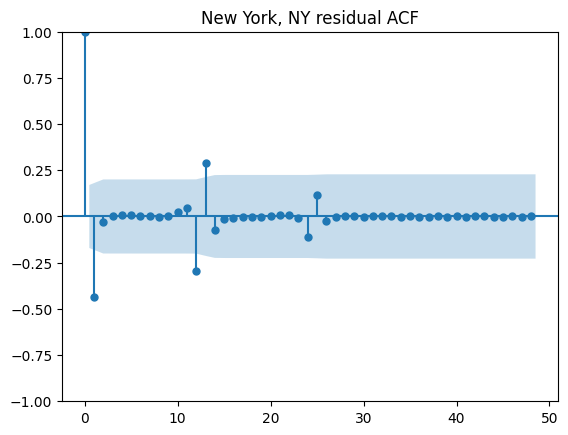

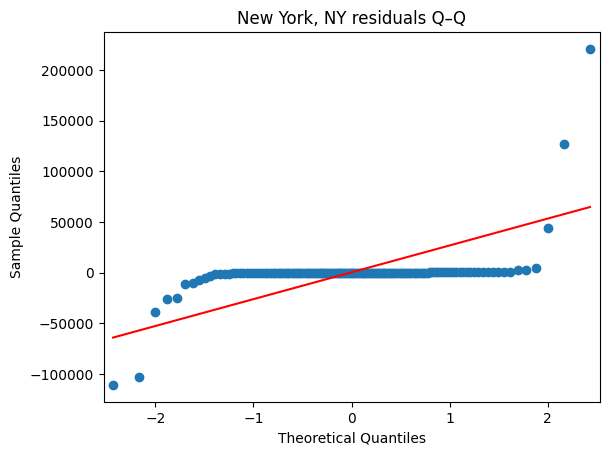

In [36]:
# === Cell 13: Diagnostics on one example fit (optional) ===
region = METROS[0]
s = series_for_region(zhvi, region)
fold = next(iter(rolling_origin_folds(s, train_min=120, val_h=12, test_h=12, step=3)))
d, D = suggest_d(fold["train"]), suggest_D(fold["train"], m=M)
best = choose_best_order_by_val(fold["train"], fold["val"], d, D, M)
res, diag = fit_sarima(pd.concat([fold["train"], fold["val"]]), best["order"], best["seasonal_order"])
print(region, "best:", best["order"], best["seasonal_order"], "LB p:", diag["lb_pvalue"])

plot_acf(res.resid.dropna(), lags=48)
plt.title(f"{region} residual ACF"); plt.show()

import statsmodels.api as sm
sm.qqplot(res.resid.dropna(), line="s")
plt.title(f"{region} residuals Q–Q"); plt.show()
